My goal with this analysis, is to get a better understanding of using pyspark for conducting machine learning, as this is my first time using pyspark.

This analysis can be replicated using Pandas and SKLearn, however that might be a project for a different time, and I would also try a different approach to the modeling than what was followed here - trying different modeling techniques and dealing with anomalies in the data differently.

https://www.kaggle.com/sharansalem/fraud-detection-eda-modelling

https://www.kaggle.com/tewedj/fraud-detection-paysim
# Ethical considerations prior to beginning the analysis

Prior to beginning any analysis, we need to determine if there are any ethical issues that might arise, considering the project at hand.

In this instance, we are predicting whether or not a transaction is fraudulent.

The project as a whole, does not appear to target anything that might be considered unethical - you would like to prevent all people from having their money stolen (vs just a subgroup).  The data has also been anonymised and simulated, so investigating the outcomes for specific biases will be difficult.

I also believe that my analysis will have minimal risk of being adapted and used for nefarious purposes.

Considering this, I believe the analysis can go forward.


## Start with importing the packages

Something to note is that specific packages used in specific circumstances, might be imported down the line, else they will be noted in the comments

Links to take note of, that I can refer back to as and when needed during the analysis.

    https://towardsdatascience.com/exploratory-data-analysis-eda-with-pyspark-on-databricks-e8d6529626b1
    
    https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_Cheat_Sheet_Python.pdf
    
    https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf
    
    https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as psf
import pandas as pd
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# To be used in data manipulation
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import substring, greatest, col, log, countDistinct

# Used to calculate missing values in the data
from pyspark.sql.functions import isnan, when, count, col

In [3]:
# Set options for packages imported
sns.set_style('darkgrid')
plt.style.use('seaborn-colorblind')
sns.set(font_scale = 1.25)


#The same seed be used for all randomisation
seed = 1234
%matplotlib inline
pd.set_option('display.max_columns', None)

Create my Spark Context, and naming the app so I know which session is which when looking at the Yarn interface

In [4]:
spark = SparkSession.builder.appName('Training_fraud').getOrCreate()
sc = SparkContext.getOrCreate()


## Importing the data

In [5]:
# Import using pandas to read the CSV file
data_path = '/home/a197135/Projects/Paysim/Dataset.csv'
panda_df = pd.read_csv(data_path)
# panda_df.head()

# Convert the pandas dataframe to a spark dataframe, using the spark app
df = spark.createDataFrame(panda_df)
df.limit(5).toPandas()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Anonymisation
Looking at the data, we can see that it has been anonymized as described in the metadata. 

There is no clear indication of personal details of customers.

An ethical consideration, would have been whether or not you would have the opportunity (albeit inadvertantly) to build a model that discriminates based on age, gender, race or any other factor.  The anonimisation makes this difficult to impossible in this instance.  

The anonymisation does eliminate discrimination from a developer perspective, but certain characteristics in the data could still influence it (for instance - what if the particular product under investigation was only marketed in certain areas which has a higher population of certain ethnic groups)

In [6]:
# Get data types of columns to see if the imported correctly
df.dtypes

[('step', 'bigint'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'bigint'),
 ('isFlaggedFraud', 'bigint')]

In [7]:
# Dataframe dimensions to get an idea of the scale of the data
print(f"This dataframe has {df.count()} rows and {len(df.columns)} columns.")

This dataframe has 6362620 rows and 11 columns.


In [8]:
# Check summary statistics, sending the result to pandas, to more neatly format it for viewing and comparison
df.summary().toPandas()

,summary,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
1,mean,243.39724563151657,None,179861.9035491309,None,833883.1040744865,855113.6685785898,None,1100701.6665196477,1224996.3982019306,0.001290820448180152,2.51468734577894E-6
2,stddev,142.33197104912952,None,603858.2314629359,None,2888242.673037557,2924048.502954264,None,3399180.112994476,3674128.942119631,0.035904796801604126,0.0015857747057365476
3,min,1,CASH_IN,0.0,C1000000639,0.0,0.0,C1000004082,0.0,0.0,0,0
4,25%,156,None,13396.48,None,0.0,0.0,None,0.0,0.0,0,0
5,50%,239,None,74869.59,None,14211.0,0.0,None,132942.52,215098.03,0,0
6,75%,335,None,208761.22,None,107350.0,144436.3,None,943050.31,1111964.4,0,0
7,max,743,TRANSFER,9.244551664E7,C999999784,5.958504037E7,4.958504037E7,M999999784,3.5601588935E8,3.5617927892E8,1,1


There appears to be some outlying values for various fields, I would like to investigate how skew the data is as well.

In [9]:
# Look for any missing values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,0,0,0,0,0,0,0,0,0,0


**No Missing values**, which is great - this means it is not something we need to deal with.

As a first step, I want to add a feature that shows me whether or not a Merchant was part of the transaction, as I would like to use that in my profiling of the data.  This could be important in identifying fraudulent transactions.

*Although this and some other derivations constitute part of **feature engineering** implemented later on, it is something I am doing here, as I already believe it could be an important part of the EDA*.

I create an indicator variable showing whether a merchant was part of the transaction either as the Origin, Destination or either of it.

In [10]:
df = df.withColumn('merchOrig' ,(substring('nameOrig',1,1) == 'M').cast(IntegerType()))\
        .withColumn('merchDest',(substring('nameDest',1,1) == 'M').cast(IntegerType())) \
        .withColumn('merchInvolved',greatest('merchOrig' , 'merchDest'))

df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,1


I also want to include a measure for the **HOUR** of the day on which the transaction occurred.

Looking at the description of the data, the STEP field is related to the hour of the transaction within the month, so we could get the hour of the day a transaction occurred using this.

Using this information, I add the hour of the day into a feature called "txn_hour".

In [11]:
# Transaction hour
df = df.withColumn('txn_hour', (col('step') % 24) )
df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,1,1


##### Wishlist item:

All of the transactions occur only over a 1 month period, so getting the day of the month wont be relevant here, although day of the week would be something I would want to look at as well.  I dont believe that will bear fruit in this case, as the data is only for a single month. If the data was available for a period of 6 months, this would definitely be a feature I would include.

# Exploratory analysis

I want to see the distribution of transaction types to get an understanding of how the data looks, over and above the basic stats I looked at previously.

First I create a pandas dataframe, and get a *random sample* of the dataframe for plotting and EDA purposes.  

This *randomised* sample, will provide a reflective view of the actual distribution fo the data, especially considering the large sample size I am pulling.

In [12]:
# Take a 16% sample to retreive roughly 1 million records
dfp = df.sample(fraction=0.16, seed = seed).toPandas()
dfp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,3099.97,C249177573,20771.0,17671.03,M2096539129,0.0,0.00,0,0,0,1,1,1
1,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0,0,0,0,1
2,1,PAYMENT,671.64,C2033524545,15123.0,14451.36,M473053293,0.0,0.00,0,0,0,1,1,1
3,1,TRANSFER,215310.30,C1670993182,705.0,0.00,C1100439041,22425.0,0.00,0,0,0,0,0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.00,C932583850,6267.0,2719172.89,0,0,0,0,0,1


Start by looking at the distribution of transaction types in the data, as that is one of the standout categorical fields in the data:

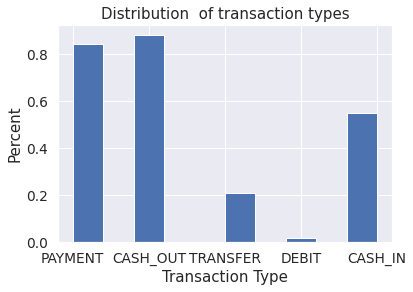

In [13]:
plt.hist(dfp['type'], density = True)
plt.title ("Distribution  of transaction types")
plt.ylabel("Percent")
plt.xlabel("Transaction Type")
plt.show()

The Majority of the Transactions are PAYMENT (34%) and CASH_OUT(34%) transactions.

DEBIT transactions are by far the least (~1%).

Considering that, how does this distribution compare to the Fraudulent transaction types that occured?

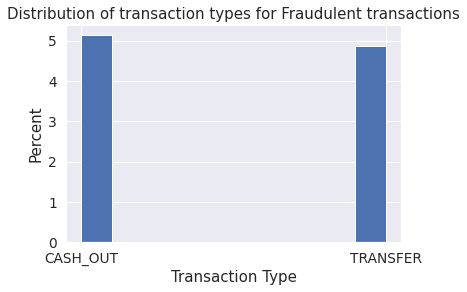

In [14]:
plt.hist  (dfp[dfp['isFraud'] == 1]['type'], density = True)
plt.title ("Distribution of transaction types for Fraudulent transactions")
plt.ylabel("Percent")
plt.xlabel("Transaction Type")
plt.show()

The_ only_ Fraudulent transactions are _Transfer and Cash Out_, with roughly equal amounts of each being made.

With "type" being a categorical variable - I want to see some descriptive statistics around the value of the transactions.

I like to view **percentiles**, as it will also give an indication on whether or not there are any outliers present.

In [15]:
#Import functions as F to help calculate the percentiles

# I perform this specifically using pyspark on the full dataframe, 
# as I would like to get an idea of the complexity of doing it via pyspark
# and potentially improve runtime as well 

import pyspark.sql.functions as F
df1 = df.groupBy('type').agg( F.expr('percentile(amount, array(0.01))')[0].alias('%01'),
                        F.expr('percentile(amount, array(0.05))')[0].alias('%05'),
                        F.expr('percentile(amount, array(0.25))')[0].alias('%25'),
                        F.expr('percentile(amount, array(0.50))')[0].alias('%50'),
                        F.expr('percentile(amount, array(0.75))')[0].alias('%75'),
                        F.expr('percentile(amount, array(0.95))')[0].alias('%95'),
                        F.expr('percentile(amount, array(0.99))')[0].alias('%99'))
df1.toPandas()

,type,%01,%05,%25,%50,%75,%95,%99
0,TRANSFER,8797.0240,43290.3600,215905.3500,486308.390,974958.0000,2.674587e+06,1.000000e+07
1,CASH_IN,2999.7394,14552.3405,70510.1825,143427.710,239899.0875,4.120051e+05,5.508709e+05
2,CASH_OUT,3107.9997,15266.7335,72669.6500,147072.185,246539.4775,4.278772e+05,5.796541e+05
3,PAYMENT,176.1900,871.6900,4383.8200,9482.190,17561.2200,3.783566e+04,5.950011e+04
4,DEBIT,68.5291,324.6730,1500.1800,3048.990,5479.1750,1.479535e+04,5.081798e+04


From the above, I can also see that TRANSFER and CASH_OUT transactions had the highest _median_ and _Maximum_ transaction values.

There appears to be **outlying** transaction amounts with all of the transaction types.  This is something I would normally deal with later on, should I want to use a model that is sensitive to outliers.

I would consider *capping* the outliers at the 95th or 99th percentile, or removing the outlying records completely, depending on whether they are found as part of a Fraudulent transaction.   

If the outliers are part of a Fraudulent transaction, I would consider adding a binary variable as well to indicate that it is an Outlying amount, along with capping the amount - this is due to the fact that it is outlying, might be relevant with regards to being Fraudulent

Considering 2 of the main features I created (txn_hour and merchInvolved), how do they relate to the transaction being fraudulent?

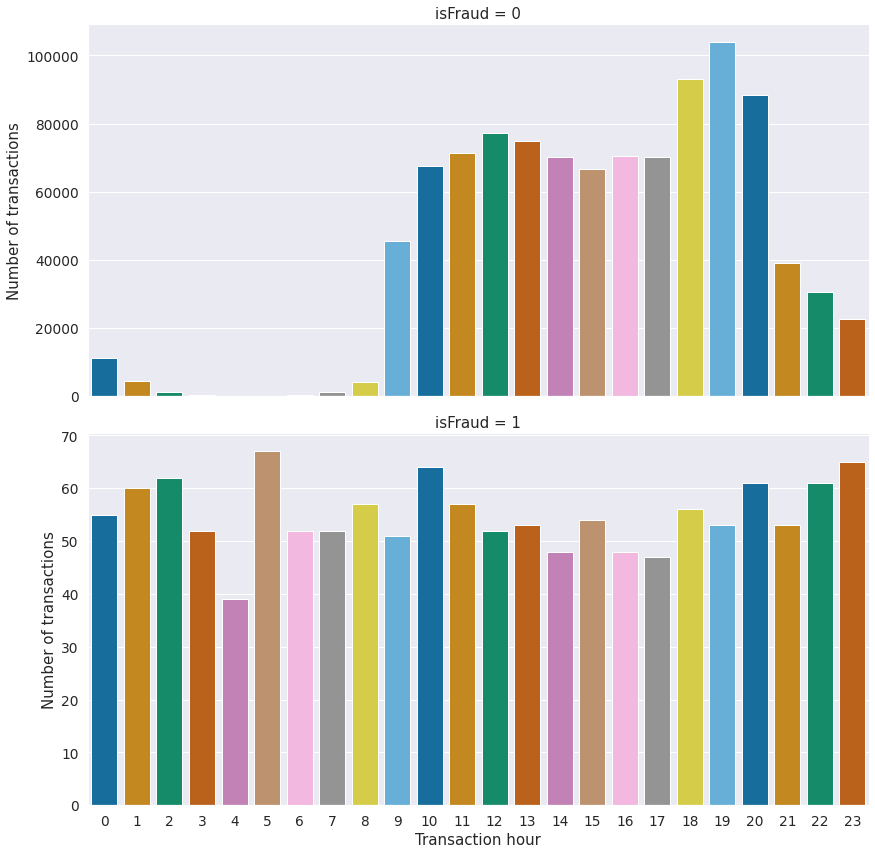

In [16]:
hour_vs_fraud = sns.catplot(  kind  ='count' 
            , x     ="txn_hour"
            , row   ='isFraud'
            , data  =dfp
            , sharey=False
            , height=6
            , aspect=2
            , palette = 'colorblind'
           )
hour_vs_fraud.set_xlabels('Transaction hour')
hour_vs_fraud.set_ylabels('Number of transactions')

plt.show()

The majority of transactions happen between 09:00 and 19:00 during the day. With some of them after hours.

Fraudulent transactions are _relatively evenly_ distributed across the day, with no clear peak value.

What does the average transaction amount look like per hour?

Text(0, 0.5, 'Avg. transaction amount (millions)')

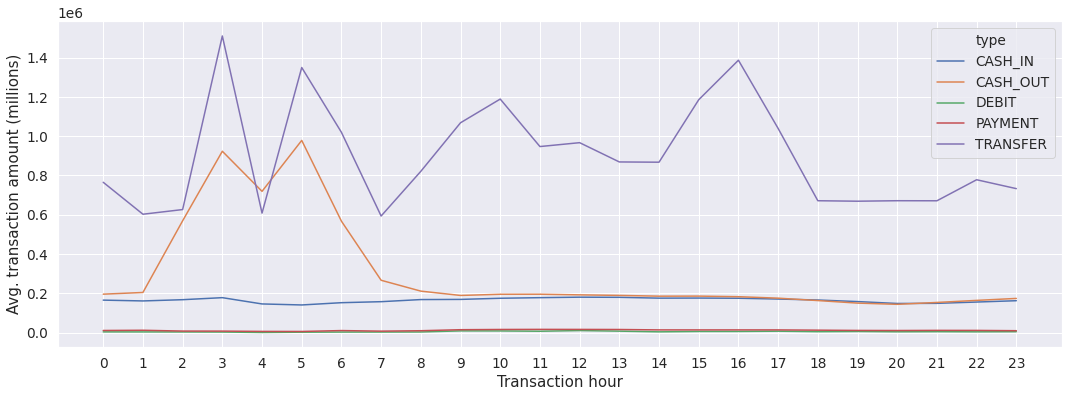

In [17]:
# Need to get the average amount per hour and plot that, 
# per transaction type and split for fraud vs non-fraud
plt.figure(figsize=(18,6))
sns.lineplot(data=dfp.groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type'
           )
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount (millions)', fontsize=15)

It is a bit hard to see the values for CASH_IN, DEBIT and PAYMENT, due to them being so small compared to the rest, so  I split them out and plot seperately.

Text(0, 0.5, 'Avg. transaction amount')

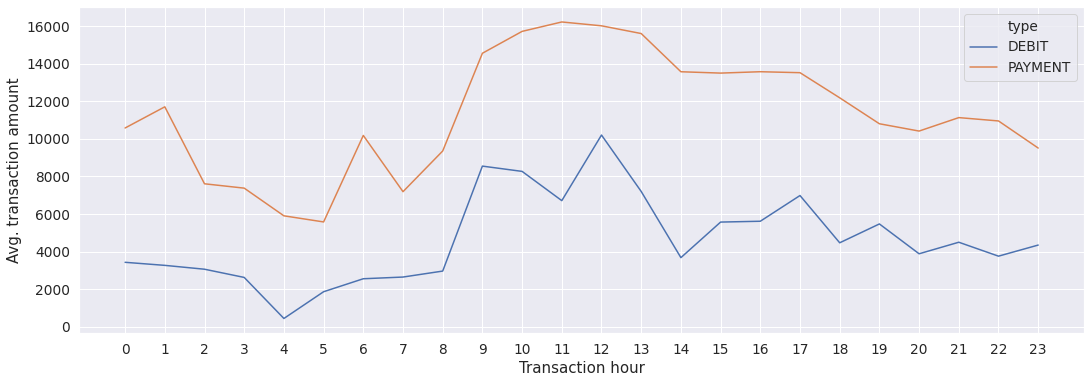

In [18]:
# Check for the ones we couldnt make out in the above graph
plt.figure(figsize=(18,6))
sns.lineplot(data=dfp[dfp['type']
                        .isin(['DEBIT','PAYMENT'])]
                 .groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type')
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount', fontsize=15)

CASH OUTS tend to happen early morning (between 03:00 and 05:00), while TRANSFERS peak very early morning (03:00), and again at 16:00

DEBITS and PAYMENTS peak between 09:00 and 13:00 during the day

What about the parties involved in the transactions? Is there a difference in times throughout the day?

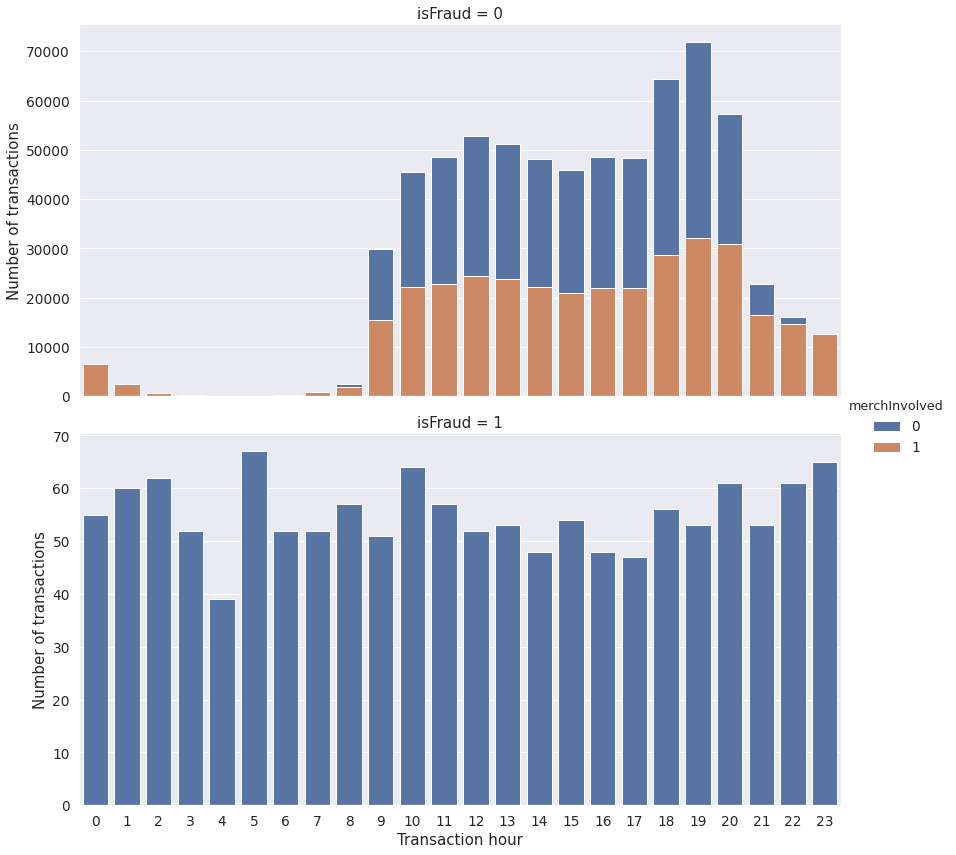

In [19]:
ax = sns.catplot(kind='bar',
            data=dfp.groupby(['txn_hour', 'merchInvolved', 'isFraud'])
                        .size().reset_index()
           , x='txn_hour'
           , y = 0
           , row ='isFraud'
           , hue='merchInvolved'
           , dodge=False
           , height=6
           , aspect=2
           , sharey=False)
ax.set_xlabels('Transaction hour', fontsize=15 )
ax.set_ylabels('Number of transactions', fontsize=15 )

Between 09:00 and 20:00, there are more transactions that do not involve a merchant, other times merchant transactions start picking up.

_None of the Fraudulent transactions had a Merchant involved in them, which makes sense as merchants would likely not commit fraud directly on their clients_

Lets look at the distribution of the various balances for both origination and destination accounts.

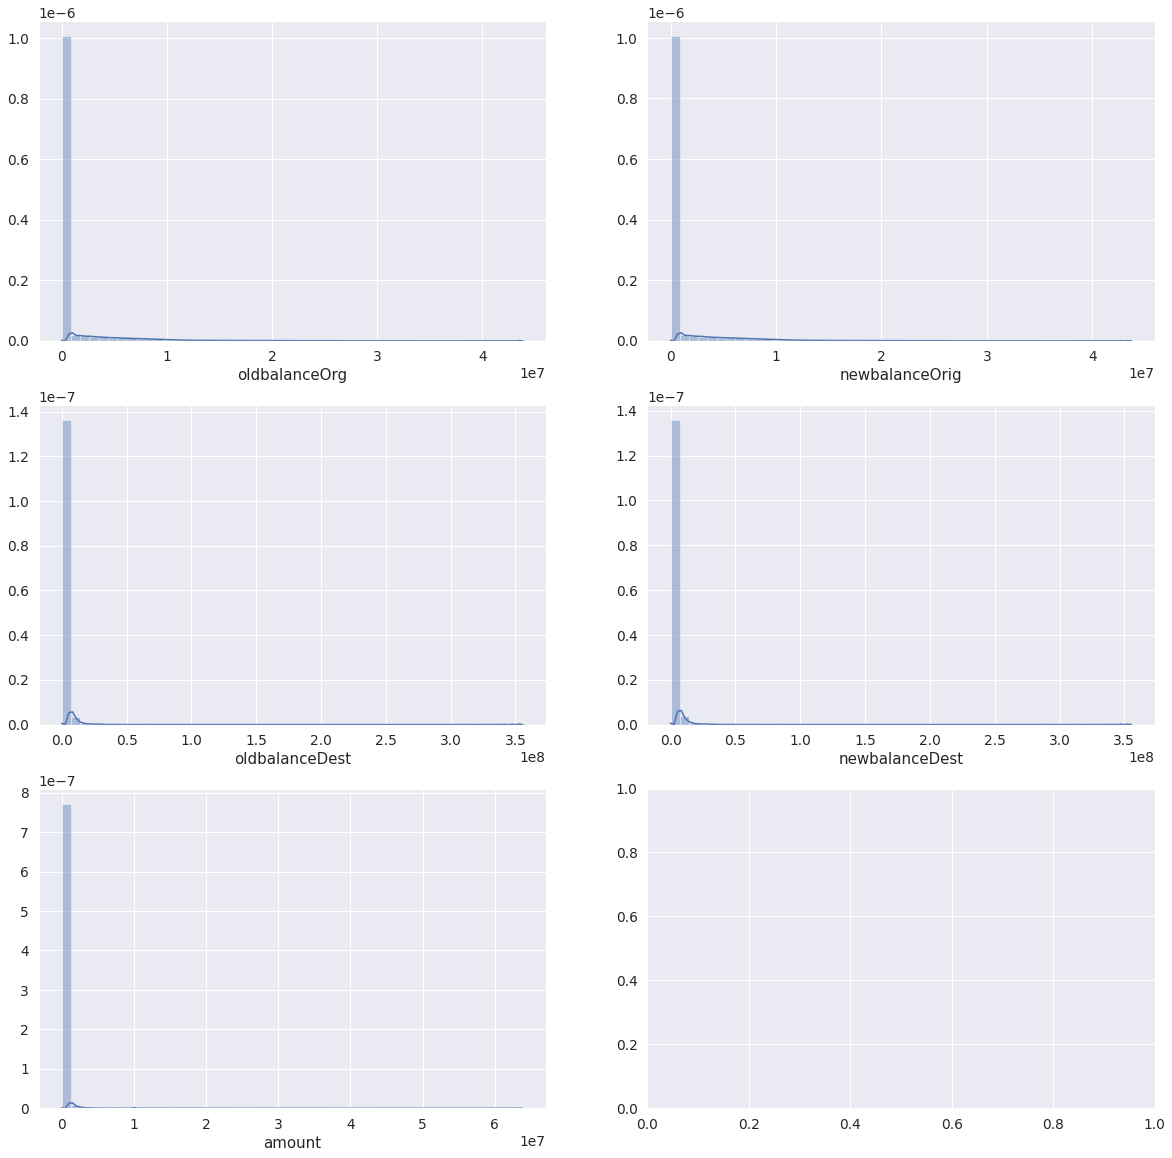

In [20]:
# balancelist = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','amount]
colorlist = ['tab:olive', 'tab:green', 'tab:blue', 'tab:cyan', 'tab:brown']

fig, axs = plt.subplots(3,2,figsize=(20, 20), sharey = False)

sns.distplot(a=(dfp['oldbalanceOrg']  ), ax=axs[0,0])
sns.distplot(a=(dfp['newbalanceOrig'] ), ax=axs[0,1])
sns.distplot(a=(dfp['oldbalanceDest'] ), ax=axs[1,0])
sns.distplot(a=(dfp['newbalanceDest'] ), ax=axs[1,1])
sns.distplot(a=(dfp['amount'] )        , ax=axs[2,0])



Most of these data points are _very skewed_ as we saw before when looking at the statistics.

I want to display the data without the massive skewness I see in there, so I am applying a _log transformation_ on everything I plot.

I also split the data for fraud vs non-fraud to see if there are differences in the distributions between the 2 sets.

In [21]:
# Create a fraud dataframe and a non-fraud dataframe
dfp_fraud    = dfp[dfp['isFraud'] == 1]
dfp_nonfraud = dfp[dfp['isFraud'] == 0]

dfp_nonfraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,3099.97,C249177573,20771.0,17671.03,M2096539129,0.0,0.00,0,0,0,1,1,1
1,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0,0,0,0,1
2,1,PAYMENT,671.64,C2033524545,15123.0,14451.36,M473053293,0.0,0.00,0,0,0,1,1,1
3,1,TRANSFER,215310.30,C1670993182,705.0,0.00,C1100439041,22425.0,0.00,0,0,0,0,0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.00,C932583850,6267.0,2719172.89,0,0,0,0,0,1


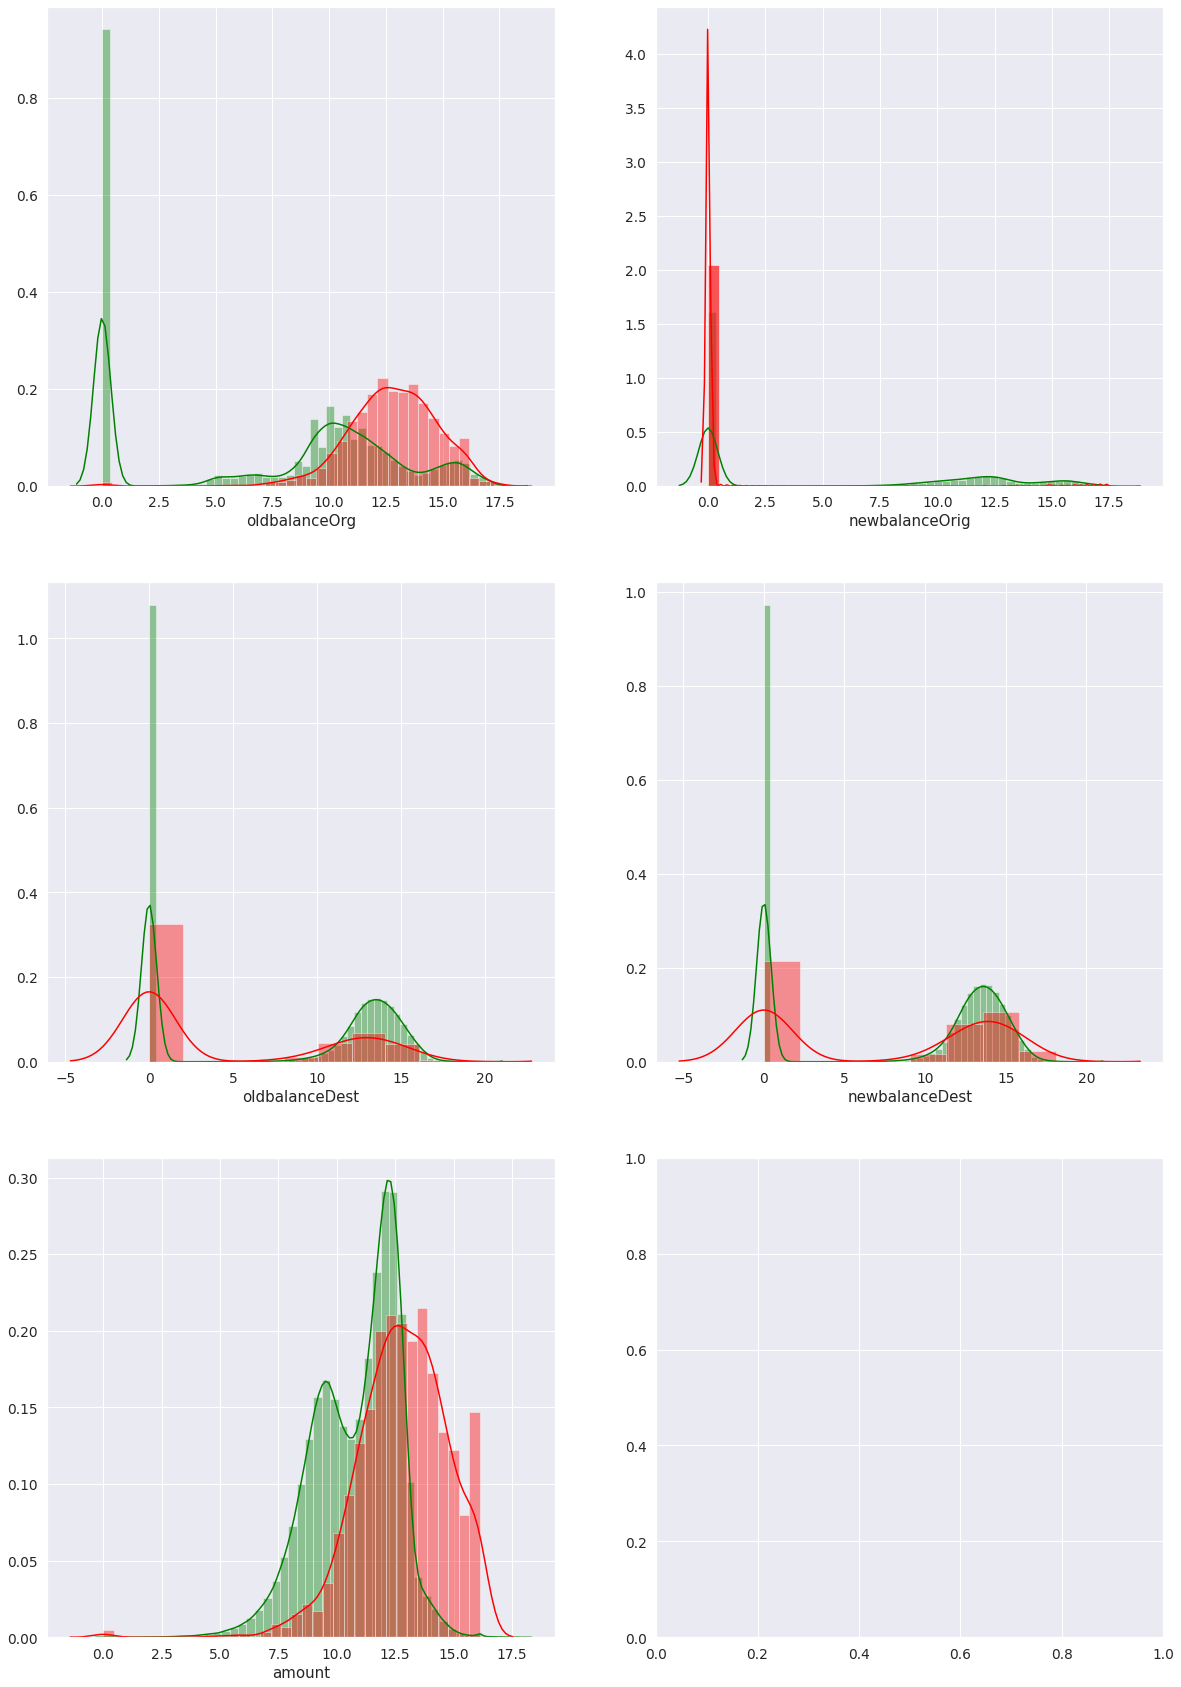

In [22]:
fig, axs = plt.subplots(3,2,figsize=(20, 30), sharey = False)

sns.distplot(a=((dfp_nonfraud['oldbalanceOrg'] +1).apply(np.log) ), ax=axs[0,0], color='green')
sns.distplot(a=(dfp_fraud['oldbalanceOrg'] +1).apply(np.log)      , ax=axs[0,0], color='red'  )

sns.distplot(a=(dfp_nonfraud['newbalanceOrig'] +1).apply(np.log) , ax=axs[0,1], color='green')
try:
    sns.distplot((dfp_fraud['newbalanceOrig'] +1).apply(np.log), color="red", ax=axs[0, 1])
except RuntimeError as re:
    if str(re).startswith("Selected KDE bandwidth is 0. Cannot estiamte density."):
        sns.distplot((dfp_fraud['newbalanceOrig'] +1).apply(np.log), kde_kws={'bw': 0.1}, ax=axs[0, 1], color="red")
    else:
        raise re

sns.distplot(a=(dfp_nonfraud['oldbalanceDest'] +1).apply(np.log) , ax=axs[1,0], color='green')
sns.distplot(a=(dfp_fraud['oldbalanceDest'] +1).apply(np.log) , ax=axs[1,0], color='red')

sns.distplot(a=(dfp_nonfraud['newbalanceDest'] +1).apply(np.log) , ax=axs[1,1], color='green')
sns.distplot(a=(dfp_fraud['newbalanceDest'] +1).apply(np.log) , ax=axs[1,1], color='red')

sns.distplot(a=(dfp_nonfraud['amount'] +1).apply(np.log)        , ax=axs[2,0], color='green')
sns.distplot(a=(dfp_fraud['amount'] +1).apply(np.log)         , ax=axs[2,0], color='red')


Amounts are skewed to the right for fraudulent transactions - _fraudulent transactions appear to be of higher value_.

Also see that there is a lot of accounts that had a _0 balance AFTER the transaction occurred_, which indicates that fraudulent transactions tend to clear out the accounts.  I will definitely create a feature for it to be included.

Something I would like to check, is whether we have multiple transactions per Customer in the data.  

Due to it being simulated, it might not be.

In [23]:
# How many unique originating and destination names are there?
# Dataframe dimensions to recap the observation count
print(f"This dataframe has {df.count()} rows. \n")

df.select(countDistinct('nameOrig')).show()
df.select(countDistinct('nameDest')).show()


This dataframe has 6362620 rows. 

+------------------------+
|count(DISTINCT nameOrig)|
+------------------------+
|                 6353307|
+------------------------+

+------------------------+
|count(DISTINCT nameDest)|
+------------------------+
|                 2722362|
+------------------------+



There appear to be _multiple transactions_ per originating and destination client/merchant.  
Meaning we might be able to generate features on what happened PRIOR to a transaction happening for each client

In [24]:
# How many transactions were there, where there are multiple?
# create a temporary view to query using spark sql
df.createOrReplaceTempView("df2")
spark.sql('select nameOrig,isFraud, count(1) as NUM_TRANS from df2 group by nameOrig, isFraud order by num_trans desc').show(10)
spark.sql('select nameDest,isFraud, count(1) as NUM_TRANS from df2 group by nameDest, isFraud order by num_trans desc').show(10)


+-----------+-------+---------+
|   nameOrig|isFraud|NUM_TRANS|
+-----------+-------+---------+
|C1902386530|      0|        3|
| C363736674|      0|        3|
|C1976208114|      0|        3|
| C545315117|      0|        3|
| C724452879|      0|        3|
|C2098525306|      0|        3|
| C400299098|      0|        3|
|C1462946854|      0|        3|
|C1832548028|      0|        3|
|C1677795071|      0|        3|
+-----------+-------+---------+
only showing top 10 rows

+-----------+-------+---------+
|   nameDest|isFraud|NUM_TRANS|
+-----------+-------+---------+
|C1286084959|      0|      113|
| C985934102|      0|      109|
| C665576141|      0|      105|
|C2083562754|      0|      102|
| C248609774|      0|      101|
|C1590550415|      0|      101|
| C451111351|      0|       99|
|C1789550256|      0|       99|
|C1360767589|      0|       98|
|C1023714065|      0|       97|
+-----------+-------+---------+
only showing top 10 rows



There are definitely clients that had multiple transactions in the data, so _creating features to characterise their behaviour prior to a new transaction, could prove valuable_.

What about fraudulent transactions - are there clients that had multiple linked to them?

In [25]:
# How many transactions were there, where there are multiple?
spark.sql('select nameOrig, count(1) as NUM_TRANS from df2 where isFraud = 1 group by nameOrig order by num_trans desc').show(10)
spark.sql('select nameDest, count(1) as NUM_TRANS from df2 where isFraud = 1 group by nameDest order by num_trans desc').show(10)


+-----------+---------+
|   nameOrig|NUM_TRANS|
+-----------+---------+
| C481315574|        1|
|C1197449290|        1|
|C1379628544|        1|
|C1367270224|        1|
|C1509490957|        1|
| C975798201|        1|
|C1563386305|        1|
|C1473713823|        1|
| C917414431|        1|
|C1511318638|        1|
+-----------+---------+
only showing top 10 rows

+-----------+---------+
|   nameDest|NUM_TRANS|
+-----------+---------+
|C1980653895|        2|
|C1497532505|        2|
|C1837027614|        2|
| C104038589|        2|
| C935310781|        2|
| C964377943|        2|
|C1827219533|        2|
| C185805228|        2|
|C1653587362|        2|
|C1780714769|        2|
+-----------+---------+
only showing top 10 rows



From the above,  we can see that there are instances of Destination clients that had multiple fraudulent transactions linked to them. 

 A business rule one could add to prevent fraudulent transactions in future, could be to perform enhanced due diligence, if funds are transferred to a nameDest, that was previously involved in fraudulent transactions

In [26]:
# Drop the temp view I used to query, to free up resources
spark.catalog.dropTempView("df2")

# Feature Engineering:

I create an indicator variable to show whether the original balance has been cleared out, identified during the initial EDA

In [27]:
df = df.withColumn('origBalanceCleared', (col('newbalanceOrig') == 0).cast(IntegerType()) )

I want to know how a client transacted BEFORE a particular transaction.

Also whether the client was involved in FRAUD before.

In [28]:
# create tables that summarise the features for the originating party and the destination party respectively
a = df.alias("a")
b = df.alias("b")

# Create a dataset to use that I can derive features for, for the Originating party in the transaction
orig_features = a.join(b,a.nameOrig == b.nameOrig  , how='left'). \
                select(col("a.nameOrig").alias("orig_nameOrig"), "a.step", col("b.step").alias("PREV_STEP"), \
                       "b.amount", "b.isFraud", "b.txn_hour", "b.merchInvolved", \
                       "b.merchOrig", "b.merchDest").where("PREV_STEP < step")

# Create a dataset to use that I can derive features for, for the Destination party in the transaction
dest_features = a.join(b,a.nameDest == b.nameDest  , how='left'). \
                select(col("a.nameDest").alias('dest_nameDest'), "a.step", col("b.step").alias("PREV_STEP"), \
                       "b.amount", "b.isFraud", "b.txn_hour", "b.merchInvolved", \
                       "b.merchOrig", "b.merchDest").where("PREV_STEP < step")


In [29]:
#Check whether it had the desired effect and summarisation I expected
orig_features.show(5)
dest_features.show(5)

+-------------+----+---------+---------+-------+--------+-------------+---------+---------+
|orig_nameOrig|step|PREV_STEP|   amount|isFraud|txn_hour|merchInvolved|merchOrig|merchDest|
+-------------+----+---------+---------+-------+--------+-------------+---------+---------+
|  C1024711243| 285|      251|  5078.55|      0|      11|            1|        0|        1|
|  C1093688058| 331|       35|  11094.0|      0|      11|            1|        0|        1|
|  C1116273726| 356|      329| 70090.94|      0|      17|            0|        0|        0|
|  C1146819885| 232|       18| 31019.88|      0|      18|            0|        0|        0|
|  C1154436417| 230|       16|396596.79|      0|      16|            0|        0|        0|
+-------------+----+---------+---------+-------+--------+-------------+---------+---------+
only showing top 5 rows

+-------------+----+---------+---------+-------+--------+-------------+---------+---------+
|dest_nameDest|step|PREV_STEP|   amount|isFraud|txn_hou

It had the effect I wanted, as I joined the table to itself, where the current transaction step is smaller than the previous one. 

Not all clients will have features here, depending on if they transacted before, or not

I group the features for the destination and the origination features.

I am interested in:

    1. How many merchants that party has transacted with previously (sum(merchInvolved)
    2. How many transactions they made previously (count(PREV_STEP))
    3. What is the average transaction amount they have made previously (avg(amount))
    4. What the average time is that transactions are usually made for them (avg(txn_hour))
    5. Whether they have been involved in Fraud before (max(isFraud))
    6. How many times they have been involved with transactions with Merchants (sum(merchInvolved))
    7. How many times transactions were conducted where a merchant was the orginating or destination party (sum(merchOrig), sum(merchDest))

In [30]:

orig_features = orig_features.groupby('orig_nameOrig', 'step').agg({"PREV_STEP": "count", "amount" :"mean", "isFraud" :"max", \
                                              "txn_hour": "mean", "merchInvolved" : "sum", \
                                              "merchOrig" : "sum", "merchDest":"sum"}) \
                                            .withColumnRenamed("step", "orig_step")\
                                            .withColumnRenamed("sum(merchInvolved)", "prev_orig_merchInvolved_total")\
                                            .withColumnRenamed("max(isFraud)"      , "prev_orig_fraud_max")\
                                            .withColumnRenamed("avg(txn_hour)"     , "prev_orig_txn_hour_avg")\
                                            .withColumnRenamed("sum(merchDest)"    , "prev_orig_merchDest_sum")\
                                            .withColumnRenamed("avg(amount)"       , "prev_orig_avg_amount")\
                                            .withColumnRenamed("count(PREV_STEP)"  , "prev_orig_steps_num")\
                                            .withColumnRenamed("sum(merchOrig)"    , "prev_orig_merch_orig_sum")


                                
dest_features = dest_features.groupby('dest_nameDest', 'step').agg({"PREV_STEP": "count", "amount" :"mean", "isFraud" :"max", \
                                              "txn_hour": "mean", "merchInvolved" : "sum", \
                                              "merchOrig" : "sum", "merchDest":"sum"}) \
                                            .withColumnRenamed("step", "dest_step")\
                                            .withColumnRenamed("sum(merchInvolved)", "prev_dest_merchInvolved_total")\
                                            .withColumnRenamed("max(isFraud)"      , "prev_dest_fraud_max")\
                                            .withColumnRenamed("avg(txn_hour)"     , "prev_dest_txn_hour_avg")\
                                            .withColumnRenamed("sum(merchDest)"    , "prev_dest_merchDest_sum")\
                                            .withColumnRenamed("avg(amount)"       , "prev_dest_avg_amount")\
                                            .withColumnRenamed("count(PREV_STEP)"  , "prev_dest_steps_num")\
                                            .withColumnRenamed("sum(merchOrig)"    , "prev_dest_merch_orig_sum")





In [31]:
# View the dataset in Pandas
orig_features.limit(5).toPandas()
dest_features.limit(5).toPandas()

,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum
0,C100900622,237,0,0,15.214286,0,178069.52500,14,0
1,C100900622,180,0,0,15.000000,0,185323.59375,8,0
2,C1018624718,372,0,0,16.200000,0,137188.41500,10,0
3,C102795645,162,0,0,16.000000,0,142476.61500,2,0
4,C1028220012,297,0,0,14.875000,0,250465.42625,8,0


In [32]:
# join everything together into one dataframe and seeing how it joined, and if it joined correctly
df=df.join(orig_features, (df.nameOrig == orig_features.orig_nameOrig) \
        & (df.step == orig_features.orig_step), how='left')\
        .join(dest_features, (df.nameDest == dest_features.dest_nameDest) \
        & (df.step == dest_features.dest_step), how='left')
df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum
0,277,PAYMENT,5936.16,C1498829743,31973.00,26036.84,M1605563089,0.00,0.00,0,0,0,1,1,13,0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,180,CASH_IN,79675.67,C922550291,6512095.86,6591771.53,C1312463806,2925956.84,2846281.17,0,0,0,0,0,12,0,None,None,None,None,None,None,None,None,None,C1312463806,180.0,0.0,0.0,15.550000,0.0,256491.865000,20.0,0.0
2,187,PAYMENT,9515.78,C1846551737,0.00,0.00,M384977151,0.00,0.00,0,0,0,1,1,19,1,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202,PAYMENT,8517.22,C1744554804,15738.00,7220.78,M849453989,0.00,0.00,0,0,0,1,1,10,0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131,TRANSFER,449933.38,C1399950780,0.00,0.00,C26482360,2134419.01,2584352.39,0,0,0,0,0,11,1,None,None,None,None,None,None,None,None,None,C26482360,131.0,0.0,0.0,16.117647,0.0,209759.118235,17.0,0.0


In [33]:
# Have a look at the schema of the dataframe to view all the columns added and their data types
df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: long (nullable = true)
 |-- isFlaggedFraud: long (nullable = true)
 |-- merchOrig: integer (nullable = true)
 |-- merchDest: integer (nullable = true)
 |-- merchInvolved: integer (nullable = true)
 |-- txn_hour: long (nullable = true)
 |-- origBalanceCleared: integer (nullable = true)
 |-- orig_nameOrig: string (nullable = true)
 |-- orig_step: long (nullable = true)
 |-- prev_orig_merchInvolved_total: long (nullable = true)
 |-- prev_orig_fraud_max: long (nullable = true)
 |-- prev_orig_txn_hour_avg: double (nullable = true)
 |-- prev_orig_merchDest_sum: long (nullable = true)
 |-- prev_orig_avg_amount

In [34]:
df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum
0,277,PAYMENT,5936.16,C1498829743,31973.00,26036.84,M1605563089,0.00,0.00,0,0,0,1,1,13,0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,180,CASH_IN,79675.67,C922550291,6512095.86,6591771.53,C1312463806,2925956.84,2846281.17,0,0,0,0,0,12,0,None,None,None,None,None,None,None,None,None,C1312463806,180.0,0.0,0.0,15.550000,0.0,256491.865000,20.0,0.0
2,187,PAYMENT,9515.78,C1846551737,0.00,0.00,M384977151,0.00,0.00,0,0,0,1,1,19,1,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,202,PAYMENT,8517.22,C1744554804,15738.00,7220.78,M849453989,0.00,0.00,0,0,0,1,1,10,0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131,TRANSFER,449933.38,C1399950780,0.00,0.00,C26482360,2134419.01,2584352.39,0,0,0,0,0,11,1,None,None,None,None,None,None,None,None,None,C26482360,131.0,0.0,0.0,16.117647,0.0,209759.118235,17.0,0.0


# FEATURE ENGINEERING PART 2

Owing to the _skewness_ of some of the data, I am also going to apply a LOG transformation to the numeric columns I plotted before, to deal with the skewness and create the new features I actually want to model on (although my aim is not to use any modeling techniques that will be significantly influenced in the skewness of the data).

Since some variables have a 0 in them, I take the log + 1 of everything as the log of 0 does not exist.

In [35]:
df =df.withColumn('log_oldbalanceOrg'  , log(col('oldbalanceOrg')+1 )) \
      .withColumn('log_newbalanceOrig' , log(col('newbalanceOrig')+1 )) \
      .withColumn('log_oldbalanceDest' , log(col('oldbalanceDest')+1 ))  \
      .withColumn('log_newbalanceDest' , log(col('newbalanceDest') +1 ))  \
      .withColumn('log_amount'         , log(col('amount')+1 ))\
      .withColumn('log_prev_orig_avg_amount'         , log(col('prev_orig_avg_amount')+1 )) \
      .withColumn('log_prev_dest_avg_amount'         , log(col('prev_dest_avg_amount')+1 ))

df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount
0,19,TRANSFER,203107.47,C733503967,0.00,0.00,C1000015936,237744.71,440852.18,0,0,0,0,0,19,1,None,None,None,None,None,None,None,None,None,C1000015936,19.0,0.0,0.0,18.000,0.0,227701.7100,2.0,0.0,0.000000,0.000000,12.378957,12.996467,12.221495,None,12.335796
1,19,CASH_IN,174852.96,C186347284,642320.09,817173.05,C1000015936,440852.18,380067.19,0,0,0,0,0,19,0,None,None,None,None,None,None,None,None,None,C1000015936,19.0,0.0,0.0,18.000,0.0,227701.7100,2.0,0.0,13.372844,13.613607,12.996467,12.848106,12.071706,None,12.335796
2,228,CASH_IN,313011.71,C356949011,19347.00,332358.71,C1000094209,391282.07,78270.36,0,0,0,0,0,12,0,None,None,None,None,None,None,None,None,None,C1000094209,228.0,0.0,0.0,14.300,0.0,180683.7920,10.0,0.0,9.870344,12.713973,12.877187,11.267937,12.653999,None,12.104509
3,43,CASH_OUT,13574.32,C1743534410,92101.00,78526.68,C1000374016,0.00,0.00,0,0,0,0,0,19,0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.430652,11.271206,0.000000,0.000000,9.516009,None,NaN
4,227,CASH_OUT,43351.09,C1592067933,15220.00,0.00,C100042918,1793022.76,1836373.85,0,0,0,0,0,11,1,None,None,None,None,None,None,None,None,None,C100042918,227.0,0.0,0.0,16.125,0.0,229950.8825,8.0,0.0,9.630431,0.000000,14.399414,14.423304,10.677110,None,12.345625


I also want to calculate the difference between general time someone has previously done transactions and the current transaction under investigation (either the originating or destination party), as transactions that happen at a different time than normal for a client, might be fraudulent.

In [36]:
# Difference between avg hour and actual hour of transaction
df =df.withColumn('hour_diff_orig',  (col('txn_hour') - col('prev_orig_txn_hour_avg')))\
      .withColumn('hour_diff_dest',  (col('txn_hour') - col('prev_dest_txn_hour_avg')))\



I also want to calculate the difference between average transaction amount someone has previously done and the current transaction under investigation (either the originating or destination party).

In [37]:
# difference between the average amount and the transaction amount
df =df.withColumn('amt_diff_orig',    col('amount') - col('prev_orig_avg_amount')) \
      .withColumn('amt_diff_dest',    col('amount') - col('prev_dest_avg_amount'))

# Look at the data to see if the calculation happened correctly
df.limit(5).toPandas()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest
0,19,TRANSFER,203107.47,C733503967,0.00,0.00,C1000015936,237744.71,440852.18,0,0,0,0,0,19,1,None,None,None,None,None,None,None,None,None,C1000015936,19.0,0.0,0.0,18.000,0.0,227701.7100,2.0,0.0,0.000000,0.000000,12.378957,12.996467,12.221495,None,12.335796,None,1.000,None,-24594.2400
1,19,CASH_IN,174852.96,C186347284,642320.09,817173.05,C1000015936,440852.18,380067.19,0,0,0,0,0,19,0,None,None,None,None,None,None,None,None,None,C1000015936,19.0,0.0,0.0,18.000,0.0,227701.7100,2.0,0.0,13.372844,13.613607,12.996467,12.848106,12.071706,None,12.335796,None,1.000,None,-52848.7500
2,228,CASH_IN,313011.71,C356949011,19347.00,332358.71,C1000094209,391282.07,78270.36,0,0,0,0,0,12,0,None,None,None,None,None,None,None,None,None,C1000094209,228.0,0.0,0.0,14.300,0.0,180683.7920,10.0,0.0,9.870344,12.713973,12.877187,11.267937,12.653999,None,12.104509,None,-2.300,None,132327.9180
3,43,CASH_OUT,13574.32,C1743534410,92101.00,78526.68,C1000374016,0.00,0.00,0,0,0,0,0,19,0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.430652,11.271206,0.000000,0.000000,9.516009,None,NaN,None,NaN,None,NaN
4,227,CASH_OUT,43351.09,C1592067933,15220.00,0.00,C100042918,1793022.76,1836373.85,0,0,0,0,0,11,1,None,None,None,None,None,None,None,None,None,C100042918,227.0,0.0,0.0,16.125,0.0,229950.8825,8.0,0.0,9.630431,0.000000,14.399414,14.423304,10.677110,None,12.345625,None,-5.125,None,-186599.7925


#### Split the data into Training and test data.

Although there is still some feature engineering to happen, I split between Training and Testing set now to prevent any data leakage occuring between the training and test dataset.

In [38]:
train, test = df.randomSplit([0.8, 0.2], seed=seed)

In [39]:
# Import the necessary packages for one hot encoding of the transaction_types
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

Considering that we have some _categorical_ variables in the data, I want to convert this to numerical features.

Need to create some dummy variables for the transaction types.

The main feature we are looking to convert to numerical, is the transaction type and the tranaction hour in which the transaction happened.

In [40]:
# StringIndex the values in the variable to feed it into a OneHotEncoder to encode into a numerical value
txn_string    = StringIndexer(inputCol='type'    , outputCol='type_idx' )   
txn_one_hot   = OneHotEncoder(inputCol='type_idx', outputCol='type_code', dropLast = False)

# Fit the pipeline to the training table
onehot_pipe_mdl = Pipeline(stages= [txn_string , txn_one_hot]).fit(train)

# Apply the pipeline to the training and test dataset.  The encoding needs to happen on the training set,
# but both need to be transformed using that encoding
train = onehot_pipe_mdl.transform(train)
test  = onehot_pipe_mdl.transform(test)

In [41]:
# Create some dummy values for the txn_hour, as that is categorical and could be useful in the model
# no need to apply a stringindexer to the variable is numeric and can be encoded as is
txn_one_hot         = OneHotEncoder(inputCol='txn_hour', outputCol='txn_hour_code', dropLast = False)

# Fit the pipeline to the training set
txn_onehot_pipe_mdl = Pipeline(stages=[txn_one_hot]).fit(train)

# Apply the pipeline to the training and test dataset.  The encoding needs to happen on the training set,
# but both need to be transformed using that encoding
train = txn_onehot_pipe_mdl.transform(train)
test  = txn_onehot_pipe_mdl.transform(test)

In [42]:
# Investigate the training data to see if it applied appropriately
train.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,type_idx,type_code,txn_hour_code
0,1,CASH_IN,285578.26,C1521389237,2867674.55,3153252.80,C1721246982,1400365.47,1114787.21,0,0,0,0,0,1,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,14.869012,14.963945,14.152245,13.924175,12.562275,None,None,None,None,None,None,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,CASH_IN,348463.93,C352378889,2636316.14,2984780.07,C1721246982,1531575.72,1114787.21,0,0,0,0,0,1,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,14.784893,14.909037,14.241808,13.924175,12.761293,None,None,None,None,None,None,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,PAYMENT,613.83,C1644864746,368.00,0.00,M766696861,0.00,0.00,0,0,0,1,1,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5.910797,0.000000,0.000000,0.000000,6.421346,None,None,None,None,None,None,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,PAYMENT,2891.70,C800497654,0.00,0.00,M215632153,0.00,0.00,0,0,0,1,1,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.000000,0.000000,0.000000,0.000000,7.969946,None,None,None,None,None,None,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,PAYMENT,3644.85,C2030138610,24111.00,20466.15,M1109752797,0.00,0.00,0,0,0,1,1,1,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,10.090465,9.926576,0.000000,0.000000,8.201345,None,None,None,None,None,None,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Some of the new features I created, have some missing values in it, due to the clients, for example, never having done transactions before. 

In this instance, I am NOT going to impute them with anything other than a 0, as I do not plan on using any models that are sensitive to missing values.

However - I would have imputed some values with 0 and some with the average, depending on the context of the specific feature

In [43]:
# Fill all NULL values in the dataframe with a 0
train = train.fillna(value=0)
test  = test.fillna(value=0)

In [44]:
# Obtain the column names of the dataframe, to get the features I want to model on
train.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'merchOrig',
 'merchDest',
 'merchInvolved',
 'txn_hour',
 'origBalanceCleared',
 'orig_nameOrig',
 'orig_step',
 'prev_orig_merchInvolved_total',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchDest_sum',
 'prev_orig_avg_amount',
 'prev_orig_steps_num',
 'prev_orig_merch_orig_sum',
 'dest_nameDest',
 'dest_step',
 'prev_dest_merchInvolved_total',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchDest_sum',
 'prev_dest_avg_amount',
 'prev_dest_steps_num',
 'prev_dest_merch_orig_sum',
 'log_oldbalanceOrg',
 'log_newbalanceOrig',
 'log_oldbalanceDest',
 'log_newbalanceDest',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'type_idx',
 'type_code',
 'txn_hour_code']

In [45]:
not_model = ['type_idx','step','type','nameOrig','nameDest','isFraud',
             'isFlaggedFraud','orig_step','dest_step','txn_hour','amount','oldbalanceOrg',
             'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
             'prev_dest_avg_amount','prev_orig_avg_amount','orig_nameOrig', 'dest_nameDest']
vector_cols = [x for x in train.columns if x not in not_model]
vector_cols

['merchOrig',
 'merchDest',
 'merchInvolved',
 'origBalanceCleared',
 'prev_orig_merchInvolved_total',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchDest_sum',
 'prev_orig_steps_num',
 'prev_orig_merch_orig_sum',
 'prev_dest_merchInvolved_total',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchDest_sum',
 'prev_dest_steps_num',
 'prev_dest_merch_orig_sum',
 'log_oldbalanceOrg',
 'log_newbalanceOrig',
 'log_oldbalanceDest',
 'log_newbalanceDest',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'type_code',
 'txn_hour_code']

In [46]:
train.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = false)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = false)
 |-- newbalanceOrig: double (nullable = false)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = false)
 |-- newbalanceDest: double (nullable = false)
 |-- isFraud: long (nullable = true)
 |-- isFlaggedFraud: long (nullable = true)
 |-- merchOrig: integer (nullable = true)
 |-- merchDest: integer (nullable = true)
 |-- merchInvolved: integer (nullable = true)
 |-- txn_hour: long (nullable = true)
 |-- origBalanceCleared: integer (nullable = true)
 |-- orig_nameOrig: string (nullable = true)
 |-- orig_step: long (nullable = true)
 |-- prev_orig_merchInvolved_total: long (nullable = true)
 |-- prev_orig_fraud_max: long (nullable = true)
 |-- prev_orig_txn_hour_avg: double (nullable = false)
 |-- prev_orig_merchDest_sum: long (nullable = true)
 |-- prev_orig_avg_

# Build some models

I believe I can now start building a model on the dataset to predict fraudulent transactions.

Import the packages related to model building (I will to this when needed during the process):

In [47]:
# to assemble the vector for model building
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

# for gridsearch
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [48]:
assembler = VectorAssembler(inputCols=vector_cols, outputCol = 'feature_vector' )

train_model = assembler.transform(train)
test_model  = assembler.transform(test)

In [49]:
train_model.limit(5).toPandas()
test_model.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,type_idx,type_code,txn_hour_code,feature_vector
0,1,CASH_IN,33692.43,C507765539,3773118.02,3806810.45,C1721246982,1114787.21,1259045.81,0,0,0,0,0,1,0,None,0,0,0,0.0,0,0.0,0,0,None,0,0,0,0.0,0,0.0,0,0,15.143413,15.152303,13.924175,14.045865,10.425058,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,CASH_IN,123545.77,C261567641,198491.56,322037.33,C1721246982,1739653.99,1114787.21,0,0,0,0,0,1,0,None,0,0,0,0.0,0,0.0,0,0,None,0,0,0,0.0,0,0.0,0,0,12.198507,12.682426,14.369197,13.924175,11.724375,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,CASH_IN,215742.75,C1350720002,804748.56,1020491.31,C1721246982,1616108.22,1114787.21,0,0,0,0,0,1,0,None,0,0,0,0.0,0,0.0,0,0,None,0,0,0,0.0,0,0.0,0,0,13.598286,13.835796,14.295532,13.924175,12.281847,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,TRANSFER,556542.19,C1046056441,0.00,0.00,C1721246982,1183111.79,1114787.21,0,0,0,0,0,1,1,None,0,0,0,0.0,0,0.0,0,0,None,0,0,0,0.0,0,0.0,0,0,0.000000,0.000000,13.983659,13.924175,13.229500,0.0,0.0,0.0,0.0,0.0,0.0,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,PAYMENT,7543.10,C566860479,136506.00,128962.90,M1836018857,0.00,0.00,0,0,0,1,1,5,0,None,0,0,0,0.0,0,0.0,0,0,None,0,0,0,0.0,0,0.0,0,0,11.824131,11.767288,0.000000,0.000000,8.928521,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [50]:
# Create various Estimators
rf = RandomForestClassifier(labelCol='isFraud', 
                            featuresCol='feature_vector')

gbt = GBTClassifier(labelCol='isFraud', 
                    featuresCol='feature_vector', seed=seed)


binary_eval = BinaryClassificationEvaluator(labelCol = 'isFraud', metricName='areaUnderROC')

In [51]:
# Create the parameter grid for the Random Forest
params_rf = ParamGridBuilder() \
            .addGrid(rf.maxDepth , [5,10,15]) \
            .addGrid(rf.numTrees, [5,10,15]) \
            .build()
#             
# Best model:
    
# params_rf = ParamGridBuilder() \
#             .addGrid(rf.maxDepth , [15]) \
#             .addGrid(rf.numTrees, [15]) \
#             .build()


In [52]:
# Create the parameter grid for the GBT
params_gbt = ParamGridBuilder() \
            .addGrid(gbt.maxDepth , [5,7,9,11]) \
            .addGrid(gbt.subsamplingRate , [0.1, 0.05,0.2, 0.15]) \
            .build()
            
# Best model:
# params_gbt = ParamGridBuilder() \
#             .addGrid(gbt.maxDepth , [11]) \
#             .addGrid(gbt.subsamplingRate , [0.15]) \
#             .build() 

In [53]:
# Create the cross validation objects
cv = CrossValidator(estimator = rf
                   ,estimatorParamMaps=params_rf
                   ,evaluator=binary_eval
                   ,numFolds=5
                   ,seed=seed
                   ,parallelism = 4)

cvgbt = CrossValidator(estimator = gbt
                   ,estimatorParamMaps=params_gbt
                   ,evaluator=binary_eval
                   ,numFolds=5
                   ,seed=seed
                   ,parallelism = 4)

In [54]:
# Fit the random forest cross validator object
cv_rf_model = cv.fit(train_model)

In [55]:
# Fit the GBT cross validator object to the data
cv_gbt_model = cvgbt.fit(train_model)

In [56]:
print("The best Max Depth value the cross validation was able to achieve using the random forest, was: " + str(cv_rf_model.bestModel._java_obj.getMaxDepth()) + "\n")
print("The best Number of Trees value the cross validation was able to achieve using the random forest, was: " + str(cv_rf_model.bestModel._java_obj.getNumTrees()) + "\n")
print("The Random Forest model was able to achieve an average AUC on the Training data of: " + str(np.mean(cv_rf_model.avgMetrics)))

The best Max Depth value the cross validation was able to achieve using the random forest, was: 15

The best Number of Trees value the cross validation was able to achieve using the random forest, was: 15

The Random Forest model was able to achieve an average AUC on the Training data of: 0.989909173538385


In [57]:
print("The best Max Depth value the cross validation was able to achieve using the GBT, was: " + str(cv_gbt_model.bestModel._java_obj.getMaxDepth()) + "\n")
print("The best subsamplingRate value the cross validation was able to achieve using the GBT, was: " + str(cv_gbt_model.bestModel._java_obj.getSubsamplingRate()) + "\n")
print("The GBT model was able to achieve an average AUC on the Training data of: " + str(np.mean(cv_gbt_model.avgMetrics)))


The best Max Depth value the cross validation was able to achieve using the GBT, was: 11

The best subsamplingRate value the cross validation was able to achieve using the GBT, was: 0.1

The GBT model was able to achieve an average AUC on the Training data of: 0.9935088165779006


##### Extract feature importances by name

Doing some reasearch, I came across a function at the below link, that extracts the feature importances of a model, along with their names and returns it as a list. 

I define this function to use on my side.

https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

In [58]:
# Extract feature importances from a tree based model, including their names
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))



In [59]:
print("Feature importances for the Random Forest model: \n")
ExtractFeatureImp(cv_rf_model.bestModel.featureImportances, train_model, "feature_vector").head(10)

Feature importances for the Random Forest model: 



,idx,name,score
19,19,log_newbalanceDest,0.245809
16,16,log_oldbalanceOrg,0.242476
30,30,type_code_TRANSFER,0.070446
18,18,log_oldbalanceDest,0.060810
20,20,log_amount,0.058896
27,27,type_code_CASH_OUT,0.040462
3,3,origBalanceCleared,0.039203
17,17,log_newbalanceOrig,0.037841
14,14,prev_dest_steps_num,0.033018
37,37,txn_hour_code_5,0.022290


From the above, the Random Forest considered the new balance of the destination account, and the old balance of the origination account to be the most important in identifying whether a transaction is fraudulent or not.  This makes sense, as we've previously seen the Fraudulent transactions tend to clean out the old balance of the account

In [60]:
print("Feature importances for the Gradient Boosted Tree model: \n")
ExtractFeatureImp(cv_gbt_model.bestModel.featureImportances, train_model, "feature_vector").head(10)

Feature importances for the Gradient Boosted Tree model: 



,idx,name,score
16,16,log_oldbalanceOrg,0.208706
19,19,log_newbalanceDest,0.110504
20,20,log_amount,0.103040
12,12,prev_dest_txn_hour_avg,0.080719
18,18,log_oldbalanceDest,0.076033
27,27,type_code_CASH_OUT,0.063415
14,14,prev_dest_steps_num,0.053589
3,3,origBalanceCleared,0.049400
24,24,hour_diff_dest,0.037072
26,26,amt_diff_dest,0.036864


The GBT has a different set of features being considered important.

It also takes account of the old and new balance, and considers it the most important, but how the client transacted previously is considered more important in the GBT than in the random forest, and how it differs from previous transactions.  This is something very interesting to examine, as it indicates that more data and tracking the clients previous transactions over time, could indicate certain interactions that make clients susceptible to fraud.

In [61]:
# Perform predictions for each model on the test set
predictions_test_rf = cv_rf_model.transform(test_model)
predictions_test_gbt = cv_gbt_model.transform(test_model)

In [62]:
# Calculate the AUC for each model to compare
print("The Random Forest model was able to achieve an average AUC on the Training data of: " + str(np.mean(cv_rf_model.avgMetrics)))
print("AUC for the best Random Forest model on the Test set: " + str(binary_eval.evaluate(predictions_test_rf)) + "\n")

print("Average AUC for the GBT model on the Training set: " + str(np.mean(cv_gbt_model.avgMetrics)))
print("AUC for the best GBT model on the Test set: " + str(binary_eval.evaluate(predictions_test_gbt)))


The Random Forest model was able to achieve an average AUC on the Training data of: 0.989909173538385
AUC for the best Random Forest model on the Test set: 0.9972359090471026

Average AUC for the GBT model on the Training set: 0.9935088165779006
AUC for the best GBT model on the Test set: 0.9966973789733832


The GBT appears to be the best model, when looking at the test statistic, but we need to consider how it has classified and where the errors in classification occurred, to examine whether it is acceptable misclassifications.

In [63]:
# Compute the confusion matrix for each model
confusion_rf  = predictions_test_rf.groupBy('isFraud', 'prediction').count()
confusion_gbt = predictions_test_gbt.groupBy('isFraud', 'prediction').count()

In [64]:
print("Confusion Matrix for Random Forest model: \n")
confusion_rf.show()

Confusion Matrix for Random Forest model: 

+-------+----------+-------+
|isFraud|prediction|  count|
+-------+----------+-------+
|      1|       0.0|    451|
|      0|       1.0|      4|
|      0|       0.0|1270584|
|      1|       1.0|   1208|
+-------+----------+-------+



With the random forest, we are correctly identifying **71%** of fraud cases

In [67]:
print("Confusion Matrix for Gradient Boosted Tree model: \n")
confusion_gbt.show()

Confusion Matrix for Gradient Boosted Tree model: 

+-------+----------+-------+
|isFraud|prediction|  count|
+-------+----------+-------+
|      1|       0.0|    414|
|      0|       1.0|     51|
|      0|       0.0|1270537|
|      1|       1.0|   1245|
+-------+----------+-------+



With the GBT, we are correctly identifying **76%** of fraud cases.

The GBT is performing better in this instance - catching more of the True fraud cases (True Positives).   

We are making more Type I errors (predicting fraud when it is not), but less Type II errors (predicting NOT Fraud when it is Fraud).   This interaction is captured in the F1-statistic (not calculated here), which can be used to directly compare the models against one another.

Considering all the above values and inferences, I would use the GBT model to predict fraudulent transactions for this business and compile the code into production for future use. There are also some business rules that can be implemented to identify Fraud, not needing a model to identify these.  

These are:

    1. Flagging a Destination client for fraud and further investigation, should they have been involved in Fraud previously (there are clients involved and receiving multiple fraudulent payments - they should be subject to enhanced due diligence).
    2. Looking at transactions that are happening on clients accounts, where the balance gets cleared out completely.  Mostly, when Fraudulent transactions occur, the balance of the account being defrauded gets cleared to 0.

### Overall, I beleive the GBT model can be used in its current format, to flag fraudulent transactions

#### You can, however, implement certain business rules to identify potential fraudulent transactions, without having to resort to a model, which might be overkill in this instance.  The model can also be used as a "fall back", should the business rules be passed successfully.